# Modified LeNet for Traffic Signs

## Load Data

In [1]:
# Load pickled data
import pickle
import tensorflow as tf

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   39209 samples
Test Set:       12630 samples


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state=0)

print("Updated image Shape: {}".format(X_train[0].shape))
print("Updated Training Set:   {} samples".format(len(X_train)))
print("Updated Validation Set:   {} samples".format(len(X_validation)))
print("Updated Test Set:       {} samples".format(len(X_test)))

Updated image Shape: (32, 32, 3)
Updated Training Set:   31367 samples
Updated Validation Set:   7842 samples
Updated Test Set:       12630 samples


In [3]:
import cv2
import numpy as np

def preprocess(data):
    """Convert to grayscale, histogram equalize, and expand dims"""
    imgs = np.ndarray((data.shape[0], 32, 32, 3), dtype=np.uint8)
    for i, img in enumerate(data):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.equalizeHist(img)
        img = np.expand_dims(img, axis=2)
        imgs[i] = img
    return imgs

def hisEqulColor(data):
    imgs = np.ndarray((data.shape[0], 32, 32, 3), dtype=np.uint8)
    for i, img in enumerate(data):    
        ycrcb=cv2.cvtColor(img,cv2.COLOR_RGB2YCR_CB)
        channels=cv2.split(ycrcb)
        cv2.equalizeHist(channels[0],channels[0])
        cv2.merge(channels,ycrcb)
        cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2RGB,img)
        imgs[i] = img
    return imgs

def NOT_hisEqulColor(data):
    imgs = np.ndarray((data.shape[0], 32, 32, 4), dtype=np.uint8)
    for i, img in enumerate(data):    
        ycrcb=cv2.cvtColor(img,cv2.COLOR_RGB2YCR_CB)
        channels=cv2.split(ycrcb)
        cv2.equalizeHist(channels[0],channels[0])
        cv2.merge(channels,ycrcb)
        cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2RGB,img)        

        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        
        gray_img =  np.reshape(gray_img,(32,32,1))
        cv2.equalizeHist(gray_img,gray_img)       
        myvar = np.concatenate((img, gray_img), axis=2)
#        print(myvar.shape)        
    
        imgs[i] = myvar
    return imgs

X_train = NOT_hisEqulColor(X_train)
X_validation = NOT_hisEqulColor(X_validation)
X_test = NOT_hisEqulColor(X_test)

In [4]:
print(X_train.shape)

(31367, 32, 32, 4)


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

37


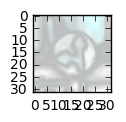

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
#plt.imshow(image, cmap='gray')
plt.imshow(image)
print(y_train[index])

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [6]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [7]:
import tensorflow as tf

EPOCHS = 25 #40
BATCH_SIZE = 128

## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [8]:
from tensorflow.contrib.layers import flatten

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.0, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # A way to get 32x32x1?  **=> Achieved 0.90 accuracy on Validation set <=**
    #C0_W = weight_variable([1,1,3,1])
    #C0_b = bias_variable([1])
    #C0 = conv2d(x, C0_W)+C0_b
    
    # TODO: Layer 1: Convolutional. Input = 32x32x4. Output = 28x28x6.
    # The shape of the filter weight is (height, width, input_depth, output_depth)
    C1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 4, 6), mean=mu, stddev=sigma), name="C1_W")
    C1_b = tf.Variable(tf.zeros(6), name="C1_b") # The shape of the filter bias is (output_depth,)
    C1_strides = [1,1,1,1] # Set the stride for each dimension (batch_size, height, width, depth)
    C1_padding = 'VALID'
    C1 = tf.nn.conv2d(x,
                      C1_W,
                      C1_strides,
                      C1_padding) + C1_b

    # TODO: Activation.
    #C1 = tf.nn.sigmoid(C1)
    C1 = tf.nn.relu(C1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    #C1 = tf.nn.avg_pool(C1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    C1 = max_pool_2x2(C1)
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    C2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma), name="C2_W")
    C2_b = tf.Variable(tf.zeros(16), name="C2_b") # The shape of the filter bias is (output_depth,)
    C2_strides = [1,1,1,1] # Set the stride for each dimension (batch_size, height, width, depth)
    C2_padding = 'VALID'
    C2 = tf.nn.conv2d(C1,
                      C2_W,
                      C2_strides,
                      C2_padding) + C2_b
    
    # TODO: Activation.
    #C2 = tf.nn.sigmoid(C2)
    C2 = tf.nn.relu(C2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    #C2 = tf.nn.avg_pool(C2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    C2 = max_pool_2x2(C2)
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    C2F = flatten(C2)

    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    FC3_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name="FC3_W")
    FC3_b = tf.Variable(tf.zeros(120), name="FC3_b")
    FC3 = tf.matmul(C2F, FC3_W) + FC3_b
    
    # SOLUTION: Activation.
    #FC3 = tf.nn.sigmoid(FC3)
    FC3 = tf.nn.relu(FC3)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    FC4_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name="FC4_W")
    FC4_b  = tf.Variable(tf.zeros(84), name="FC4_b")
    FC4    = tf.matmul(FC3, FC4_W) + FC4_b
    
    # SOLUTION: Activation.
    #FC4    = tf.nn.sigmoid(FC4)
    FC4    = tf.nn.relu(FC4)
    
    #Add DROPOUT
    h_fc1_drop = tf.nn.dropout(FC4, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    FC5_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma), name="FC5_W")
    FC5_b  = tf.Variable(tf.zeros(43), name="FC5_b")
    logits = tf.matmul(h_fc1_drop, FC5_W) + FC5_b

    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [9]:
x = tf.placeholder(tf.float32, (None, 32, 32, 4))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)


## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [10]:
#rate = 0.001

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.001
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100000, 0.96, staircase=True)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

#optimizer = tf.train.AdamOptimizer(learning_rate = rate)
#training_operation = optimizer.minimize(loss_operation)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_operation = optimizer.minimize(loss_operation, global_step=global_step)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, '.\lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.299

EPOCH 2 ...
Validation Accuracy = 0.500

EPOCH 3 ...
Validation Accuracy = 0.593

EPOCH 4 ...
Validation Accuracy = 0.662

EPOCH 5 ...
Validation Accuracy = 0.757

EPOCH 6 ...
Validation Accuracy = 0.764

EPOCH 7 ...
Validation Accuracy = 0.812

EPOCH 8 ...
Validation Accuracy = 0.837

EPOCH 9 ...
Validation Accuracy = 0.857

EPOCH 10 ...
Validation Accuracy = 0.868

EPOCH 11 ...
Validation Accuracy = 0.886

EPOCH 12 ...
Validation Accuracy = 0.898

EPOCH 13 ...
Validation Accuracy = 0.908

EPOCH 14 ...
Validation Accuracy = 0.902

EPOCH 15 ...
Validation Accuracy = 0.911

EPOCH 16 ...
Validation Accuracy = 0.918

EPOCH 17 ...
Validation Accuracy = 0.922

EPOCH 18 ...
Validation Accuracy = 0.925

EPOCH 19 ...
Validation Accuracy = 0.934

EPOCH 20 ...
Validation Accuracy = 0.930

EPOCH 21 ...
Validation Accuracy = 0.937

EPOCH 22 ...
Validation Accuracy = 0.940

EPOCH 23 ...
Validation Accuracy = 0.939

EPOCH 24 ...
Validation Accura

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.874
